# Value Iteration. Policy Iteration.

In [1]:
import gym
import os
import numpy as np
import itertools
from collections import defaultdict
from gym.envs import toy_text
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython import display
%matplotlib inline
gym.__version__

'0.17.3'

## Value Iteration

На лекции мы рассмотрели, как мы можем выучить оптимальную политику, используя алгоритм Value Iteration, если нам известна динамика среды, а также если пространства состояний и действий не большие и дискретные.

Попробуем выучить оптимальную политику в среде <a href=https://gym.openai.com/envs/FrozenLake-v0>FrozenLake-v0</a>. Это простая среда с маленькими пространствами состояний и действий, а также с известной динамикой.

Создадим среду и выведем её описание.

In [2]:
env = gym.make('FrozenLake-v0')
env.reset()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


In [3]:
print(env.env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the
    park when you made a wild throw that left the frisbee out in the middle of
    the lake. The water is mostly frozen, but there are a few holes where the
    ice has melted. If you step into one of those holes, you'll fall into the
    freezing water. At this time, there's an international frisbee shortage, so
    it's absolutely imperative that you navigate across the lake and retrieve
    the disc. However, the ice is slippery, so you won't always move in the
    direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    


Как видно среда представляет собой поле 4 на 4, по которому нужно добраться от начала (клетка *S*) до цели (клетка *G*). При этом среда является недетерменированный - с определенной вероятностью при совершения действия агент подскользнется и попадет не в ту клетку, в которую направлялся. Клетка *H* обозначает прорубь. Игра закначивается, когда агент попадает в клетку *G* или в клету *H*. Если агент проваливается в прорубь, то он получает награду *0*, если достигает клетки цели *1*. 

Посмотрим, сколько в среднем очков награды за 100 эпизодов получит наш агент, если будет выполнять случайные действия.

In [4]:
env.seed(42);

In [5]:
total_reward = []
for episode in range(100):
    episode_reward = 0
    observation = env.reset()
    for t in range(100):
        # env.render()
        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            print("Episode {} finished after {} timesteps".format(episode+1, t+1))
            break
    total_reward.append(episode_reward)

Episode 1 finished after 16 timesteps
Episode 2 finished after 7 timesteps
Episode 3 finished after 7 timesteps
Episode 4 finished after 2 timesteps
Episode 5 finished after 10 timesteps
Episode 6 finished after 7 timesteps
Episode 7 finished after 15 timesteps
Episode 8 finished after 4 timesteps
Episode 9 finished after 8 timesteps
Episode 10 finished after 10 timesteps
Episode 11 finished after 2 timesteps
Episode 12 finished after 6 timesteps
Episode 13 finished after 4 timesteps
Episode 14 finished after 7 timesteps
Episode 15 finished after 4 timesteps
Episode 16 finished after 2 timesteps
Episode 17 finished after 7 timesteps
Episode 18 finished after 11 timesteps
Episode 19 finished after 2 timesteps
Episode 20 finished after 5 timesteps
Episode 21 finished after 6 timesteps
Episode 22 finished after 2 timesteps
Episode 23 finished after 3 timesteps
Episode 24 finished after 6 timesteps
Episode 25 finished after 4 timesteps
Episode 26 finished after 10 timesteps
Episode 27 fini

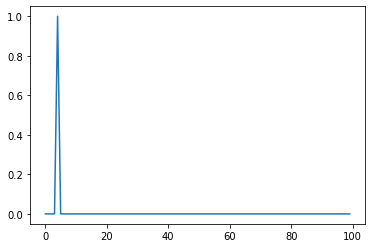

In [6]:
plt.plot(total_reward)

In [7]:
print(np.mean(total_reward))

0.01


Как видим, только в 2 эпизодах из 100 агену удалось добраться до цели.

Из среды OpenAI Gym мы можем получить элементы MDP (Markov Decision Process).

В env.env.P хранится двухуровневый словарь, в котором первый ключ является состояние, а второй - действием.
Клетки ассоциированыс индексами [0, 1, 2, ..., 15] слева направо и сверху вниз.

Индексы действией [0, 1, 2, 3] соответствуют движению на Запад, Юг, Восток и Север.
env.env.P[state][action] возвращает лист кортежей (probability, nextstate, reward). Например, состояние 0 - это начальное состояние и информация о веротностях перехода для s=0 и a=0 содержит:

In [8]:
env.env.P[0][0]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

Другой пример - состояние 5 сооветсвует проруби, и все действия в данном состоянии приводят к тому же состоянию с вероятностью 1 и наградой 0.

In [9]:
for i in range(4):
    print("P[5][%i] =" % i, env.env.P[5][i])

P[5][0] = [(1.0, 5, 0, True)]
P[5][1] = [(1.0, 5, 0, True)]
P[5][2] = [(1.0, 5, 0, True)]
P[5][3] = [(1.0, 5, 0, True)]


Вспомним, что из себя представляет алгоритм Value Iteration 
![](https://drive.google.com/uc?export=view&id=1klIcBCbPCZMp5strcJFpkgGBePYdSNqr)

Задание считается решенным, если агент доходит до цели в среднем в 70% эпизодов.

Напишем несклько вспомогательных функций.

Запомним число состояний и действий в среде.

In [10]:
n_states = env.env.nS
n_actions = env.env.nA
print("Number of states: {}".format(n_states))
print("Number of actions: {}".format(n_actions))

Number of states: 16
Number of actions: 4


Поскольку алгоритм Value Iteration возвращает нам оптимальную V-функцию, то нам необходимо извлекать из нее оптимальную политику (как указано в последней строке псевдокода алгоритма).

In [11]:
def extract_policy(v, gamma = 1.0):
    policy = np.zeros(n_states)
    for state in range(n_states):
        q = np.zeros(n_actions)
        for action in range(n_actions):
            for next_sr in env.env.P[state][action]:
                probability, next_state, reward, _ = next_sr
                q[action] += (probability*(reward + gamma*v[next_state]))
        policy[state] = np.argmax(q)
    return policy

Также напишем функцию для оценки нашей найденной политики.

In [ ]:
def evaluate_policy(env, policy, gamma=1.0, n=100):
    total_reward = []
    for episode in range(n):
        episode_reward = 0
        observation = env.reset()
        step = 0
        for _ in range(100):
            env.render()
            action = int(policy[observation])
            observation, reward, done, _ = env.step(action)
            episode_reward += gamma**step*reward
            step += 1
            if done:
                break
        total_reward.append(episode_reward)
    return np.mean(total_reward)

Нам остается написать основную функцию, которая вернет оптимальную V-функцию.

In [ ]:
def value_iteration(env, gamma=1.0, max_iterations = 100000):
    v = np.zeros(n_states)
    eps = 1e-20
    for i in range(max_iterations):
      prev_v = np.copy(v)
      
      for s in range(n_states):
        q_state_action = np.zeros(n_actions)

        for a in range(n_actions):
          q_state_action_state = 0

          for p, s_, r, _ in env.env.P[s][a]:
            q_state_action_state += p*(r + prev_v[s_])
          
          q_state_action[a] = q_state_action_state

        v[s] = max(q_state_action)
      if (np.sum(np.fabs(prev_v - v)) <= eps):
          print ('Value-iteration converged at iteration# %d.' %(i+1))
          break
    return v

In [ ]:
def value_iteration(env, gamma = 1.0):
    """ Value-iteration algorithm """
    v = np.zeros(env.env.nS)  # initialize value-function
    max_iterations = 100000
    eps = 1e-20
    for i in range(max_iterations):
        prev_v = np.copy(v)
        for s in range(env.env.nS):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.env.P[s][a]]) for a in range(env.env.nA)] 
            v[s] = max(q_sa)
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            print ('Value-iteration converged at iteration# %d.' %(i+1))
            break
    return v

Теперь мы можем найти оптимальную V-функцию, извлечь из нее оптимальную политику и оцениь ее.

In [ ]:
optimal_v = value_iteration(env)
optimal_policy = extract_policy(optimal_v)
optimal_policy_score = evaluate_policy(env, optimal_policy, n=100)

In [ ]:
print(optimal_v.reshape(4,4))

In [ ]:
print(optimal_policy.reshape(4,4))

In [ ]:
print(optimal_policy_score)

0.75


По сравнению со "случайным" агентом, который доходил до цели в 3 случаях из 100, наша новая политика позволяет добирться до цели в ~70% эпизодов.

## Policy Iteration

Вспомним, что из себя представляет алгоритм Policy Iteration
![](https://drive.google.com/uc?export=view&id=1hphERFsRFKpNcBYTSVXgInMXO1WPXKT2)

Напишем необходимые вспомогательные функции.

Начнем с основного цикла алгоритма, который вернет нам оптимальную политику.

In [ ]:
def policy_iteration(env, gamma=1.0, max_iterations = 200000):
    policy = np.random.choice(n_actions, size=(n_states))  # initialize a random policy
    for i in range(max_iterations):
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
    return policy

Остается написать 2 функции, которые используются в основном цикле алгоритма Policy Iteration согласно псевдокоду.

In [ ]:
def compute_policy_v(env, policy, gamma=1.0, eps=1e-10):
    v = np.zeros(n_states)
    # Your code goes here
    while True:
      prev_v = np.copy(v)

      for s in range(n_states):
          policy_a = policy[s]
          v[s] = 0
          for p, s_, r, _ in env.env.P[s][policy_a]:
            v[s] += p * (r + gamma * prev_v[s_])

      if (np.sum((np.fabs(prev_v - v))) <= eps):
          # value converged
          break
    return v

In [ ]:
def extract_policy(v, gamma=1.0):
    policy = np.zeros(n_states)
    # Your code goes here
    for s in range(n_states):
        q_sa = np.zeros(n_actions)
        for a in range(n_actions):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

Теперь мы также можем найти оптимальную V-функцию, извлечь из нее оптимальную политику и оцениь ее.

In [ ]:
optimal_policy = policy_iteration(env)
optimal_policy_score = evaluate_policy(env, optimal_policy)

In [ ]:
print(optimal_policy.reshape(4,4))

In [ ]:
print(optimal_policy_score)

![](https://drive.google.com/uc?export=view&id=1OlzVdezDCeeNmcEl1VQg1DmlqkA6CCBZ)